# Global Sensitivity Analysis

## Import libraries

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#import the ema_workbench libraries
from ema_workbench import (Model, MultiprocessingEvaluator, perform_experiments, ema_logging, Policy, Scenario)
from ema_workbench import (RealParameter, ScalarOutcome)
from ema_workbench.em_framework.evaluators import Samplers
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import feature_scoring

from problem_formulation import get_model_for_problem_formulation

from SALib.analyze import sobol
# from plotting_for_sobol import plot_sobol_indices, plot_scores

import statsmodels.api as sm

C:\Users\twand\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Specification of the problem
from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(3)


## Load the 'worst case scenario'
In the next cell, the worst case scenario, determined in the OpenExploration notebook, is taken to conduct the sensitivity analysis

In [4]:
load_file_name = './results/worstcase_scenario_pf1_30000_scenario.tar.gz'
experiments, outcomes = load_results(load_file_name)

#obtain the combination of externalities which lead to the worst case scenario for further analysis
xternalities_data = pd.DataFrame({k:v for k,v in experiments.items()})
xternalities_data

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,25.0,46.887554,10.0,0.108608,35.797369,1.0,0.044144,50.836164,1.0,0.035795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3878,0,dikesnet


## Set standards for analysis of worst case scenario
In the following cell, we create the worst case scenario, as described by the previously loaded data, which can be read by the model, such that later the worst case scenario can be analysed by 256 random policies for further analysis.

In [5]:
#Obtain the externality data from the 'worst case scenario file'
scenario_worst_case = [Scenario('scenario_worst', **{'discount rate 0':xternalities_data['discount rate 0'][0],
                                        'discount rate 1':xternalities_data['discount rate 1'][0],
                                        'discount rate 2':xternalities_data['discount rate 2'][0],
                                        'A.1_Bmax':xternalities_data['A.1_Bmax'][0],
                                        'A.1_Brate':xternalities_data['A.1_Brate'][0],
                                        'A.1_pfail':xternalities_data['A.1_pfail'][0],
                                        'A.2_Bmax':xternalities_data['A.2_Bmax'][0],
                                        'A.2_Brate':xternalities_data['A.2_Brate'][0],
                                        'A.2_pfail':xternalities_data['A.2_pfail'][0],
                                        'A.3_Bmax':xternalities_data['A.3_Bmax'][0],
                                        'A.3_Brate':xternalities_data['A.3_Brate'][0],
                                        'A.3_pfail':xternalities_data['A.3_pfail'][0],
                                        'A.4_Bmax':xternalities_data['A.4_Bmax'][0],
                                        'A.4_Brate':xternalities_data['A.4_Brate'][0],
                                        'A.4_pfail':xternalities_data['A.4_pfail'][0],
                                        'A.5_Bmax':xternalities_data['A.5_Bmax'][0],
                                        'A.5_Brate':xternalities_data['A.5_Brate'][0],
                                        'A.5_pfail':xternalities_data['A.5_pfail'][0],
                                        'A.0_ID flood wave shape':xternalities_data['A.0_ID flood wave shape'][0]})]

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

#Run the model over 10 processors with 256 different policies while using SOBOL sampler technique
with MultiprocessingEvaluator(dike_model, n_processes=10) as evaluator:
    exp_and_res = evaluator.perform_experiments(scenario_worst_case, policies = 256,
                                                         lever_sampling=Samplers.SOBOL)
    
# Save results
from ema_workbench import save_results
save_results(exp_and_res, './results/Worst case scenarios 256 policy Sensitivity Analysis.tar.gz')

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1 scenarios * 16384 policies * 1 model(s) = 16384 experiments
100%|████████████████████████████████████| 16384/16384 [30:43<00:00,  8.89it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\twand\OneDrive\Documenten\Msc\Q4 2021-2022\epa1361_open-master\final assignment\Worst case scenarios 256 policy Sensitivity Analysis.tar.gz


Load the previously created data for further analysis <br>
This makes it easier to use the results, instead of running the previous cell everytime we want to work with the data

In [8]:
#load results
exp_and_res = load_results('./results/Worst case scenarios 256 policy Sensitivity Analysis.tar.gz')
experiments, results = exp_and_res

[MainProcess/INFO] results loaded successfully from C:\Users\twand\OneDrive\Documenten\Msc\Q4 2021-2022\epa1361_open-master\final assignment\results\Worst case scenarios 256 policy Sensitivity Analysis.tar.gz


In [9]:
problem = get_SALib_problem(dike_model.levers)

#add all Expected number of Deaths of each dikering together via forloop
length = len(results["A.1_Expected Number of Deaths"])
expected_number_of_deaths = np.zeros(length)
for i in range(1,6):
    string = 'A.{}_Expected Number of Deaths'.format(i) #general string of dikering
    expected_number_of_deaths += results[string] #adding all results of dikerings
    
expected_number_of_deaths

array([0.03254248, 0.03254248, 0.03254248, ..., 0.22789716, 0.02734766,
       0.22789716])

In [10]:
# Convert our problem to SALib format using EMA's builtin function
problem = get_SALib_problem(dike_model.levers)

# Using the outputs and samples generated with SOBOL, do the actual global sensitivity analysis 
#(based on variations)
Si = sobol.analyze(
    problem, expected_number_of_deaths, calc_second_order=True, print_to_console=False)

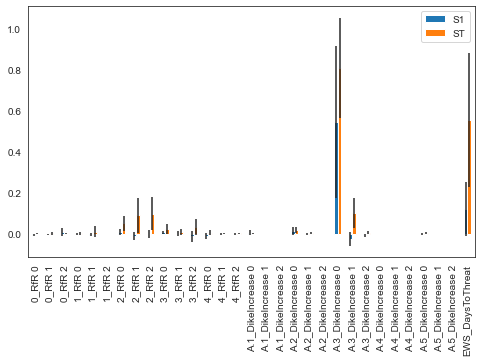

In [11]:
# Plot distributions of ST and ST1 of the values
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## Getting feature score

For the feature score to run, it needs to receive the data in the proper format:<br>
The x of the feature scoring maps need to consist of the different policy levers while the y need to consist out of the results of the analysis.

[MainProcess/INFO] results loaded successfully from C:\Users\twand\OneDrive\Documenten\Msc\Q4 2021-2022\epa1361_open-master\final assignment\results\Worst case scenarios 256 policy Sensitivity Analysis.tar.gz
C:\Users\twand\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\twand\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\twand\miniconda3\lib\site-packages\ema_workbench\analysis\feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
C:\Users\twand\miniconda3\lib\site-packages\sklearn\ensemble\_for

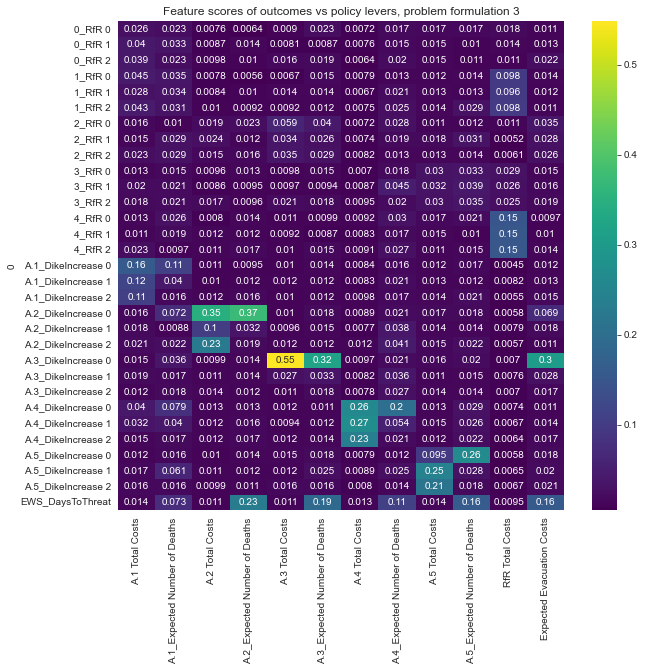

In [14]:
#load the data 
exp_and_res = load_results('./results/Worst case scenarios 256 policy Sensitivity Analysis.tar.gz')
experiments, results = exp_and_res

#slice the data
x = experiments.iloc[:,19:-3] #slice the experiments that only the different policy options are given
y = results

plt.rcParams["figure.figsize"] = (10,9)
sns.color_palette("Paired")
# Get feature scores for the SOBOL sampled inputs and their corresponding outputs
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, annot=True, cmap='viridis')
plt.title('Feature scores of outcomes vs policy levers, problem formulation 3')
plt.savefig('./Figures/feature_scores_PF3.png')
plt.show()